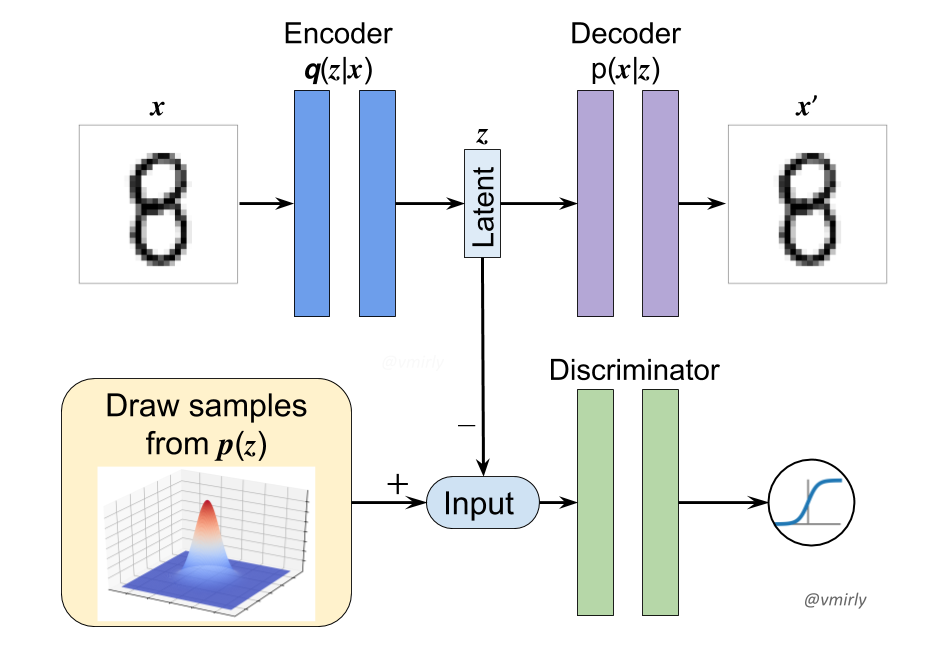

In [1]:
from IPython.display import Image
Image("figs/adversarial-autoencoder.png")

Ref: **Adversarial Autoencoders**, by A Makhzani, J Shlens, N Jaitly, I Goodfellow, and B Frey [Link to Publication:](https://arxiv.org/abs/1511.05644)

**Note:** This implementaiton uses a deterministic encoder.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [2]:
## Settings:

# CUDA Device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
batch_size = 128


Device: cuda:0


In [3]:
## MNIST Data Loader

train_dataset = datasets.MNIST(root='./mnist/', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_dataset = datasets.MNIST(root='./mnist/', 
                              train=False, 
                              transform=transforms.ToTensor())

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
images, labels = next(iter(train_loader))
print('Images dimension:', images.shape)
print('Labels dimension:', labels.shape)


Images dimension: torch.Size([128, 1, 28, 28])
Labels dimension: torch.Size([128])


# Class for Adversarial Autoencoder

  * **Encoder()**
  * **Generator()**
  * **Discriminator()**

In [5]:
class Encoder(nn.Module):
    def __init__(self, num_features, num_hidden, num_latent, num_layers):
        super(Encoder, self).__init__()
        self.num_features = num_features
        self.num_hidden = num_hidden
        self.num_latent = num_latent
        self.num_layers = num_layers
        
        layers = []
        layers.append(nn.Linear(num_features, num_hidden))
        #layers.append(nn.BatchNorm1d(num_hidden))
        layers.append(nn.ReLU(inplace=True))
        for i in range(num_layers-2):
            layers.append(nn.Linear(num_hidden, num_hidden))
            #layers.append(nn.BatchNorm1d(num_hidden))
            layers.append(nn.ReLU(inplace=True))
        #layers.append(nn.BatchNorm1d(num_hidden))
        layers.append(nn.Linear(num_hidden, 2*num_latent))
        self.main = nn.Sequential(*layers)

    def reparameterize(self, z_mu, z_sigma):
        eps = torch.randn(z_mu.size(0), z_mu.size(1))
        eps = eps.to(device)
        eps.requires_grad=False
        z_sample = z_mu + torch.mul(z_sigma, eps)
        return z_sample

    def forward(self, input_):
        outputs = self.main(input_).view(-1, 2, self.num_latent)
        z_mu, z_logvar = outputs[:, 0, :], outputs[:, 1, :]
        z_sigma = torch.exp(torch.mul(z_logvar,0.5))
        z_sample = self.reparameterize(z_mu, z_sigma)
        return z_mu, z_sigma, z_logvar, z_sample
    
class Generator(nn.Module):
    def __init__(self, num_latent, num_hidden, num_output, num_layers, last_activ='tanh'):
        super(Generator, self).__init__()
        self.num_latent = num_latent
        self.num_hidden = num_hidden
        self.num_output = num_output
        self.num_layers = num_layers
        
        layers = []
        layers.append(nn.Linear(num_latent, num_hidden))
        #layers.append(nn.BatchNorm1d(num_hidden))
        layers.append(nn.ReLU(inplace=True))
        for i in range(num_layers-2):
            layers.append(nn.Linear(num_hidden, num_hidden))
            #layers.append(nn.BatchNorm1d(num_hidden))
            layers.append(nn.ReLU(inplace=True))
        #layers.append(nn.BatchNorm1d(num_hidden))
        layers.append(nn.Linear(num_hidden, num_output))
        if last_activ == 'tanh':
            layers.append(nn.Tanh())
        elif last_activ == 'sigmoid':
            layers.append(nn.Sigmoid())
        self.main = nn.Sequential(*layers)
    
    def forward(self, input_):
        output = self.main(input_)
        return output
    
    def sample(self, n_samples):
        z_samples = torch.randn(n_samples, self.num_latent)
        z_samples = z_samples.to(device)
        z_samples.requires_grad=False
        output_samples = self.model.forward(z_samples)
        return outputs_samples.detach()
    
class Discriminator(nn.Module):
    def __init__(self, num_features, num_hidden, num_output, num_layers, gan_type='gan'):
        super(Discriminator, self).__init__()
        self.num_features = num_features
        self.num_hidden = num_hidden
        self.num_output = num_output
        
        layers = []
        layers.append(nn.Linear(num_features, num_hidden))
        layers.append(nn.ReLU(inplace=True))
        for i in range(num_layers-2):
            layers.append(nn.Linear(num_hidden, num_hidden))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(num_hidden, 1))
        if gan_type.startswith('wgan'):
            print('Wassertsein-1 GAN (WGAN or WGAN-GP)')
        elif gan_type == 'gan':
            layers.append(nn.Sigmoid()) # for GAN, not needed for WGAN
        self.main = nn.Sequential(*layers)
    
    def forward(self, input_):
        return self.main(input_)
    
## testing the classes:
enc = Encoder(784, 200, 20, 2).to(device)
z = enc(images.view(-1, 784).to(device))
print(z[0].shape, z[1].shape, z[2].shape, z[3].shape)

gen = Generator(20, 200, 784, 2, last_activ='sigmoid').to(device)
y = gen(z[3])
print(y.shape)

disc = Discriminator(20, 100, 1, 2).to(device)

print(disc(z[3]).shape)

torch.Size([128, 20]) torch.Size([128, 20]) torch.Size([128, 20]) torch.Size([128, 20])
torch.Size([128, 784])
torch.Size([128, 1])


## AAE solver

In [26]:
import torch.optim as optim

def weights_initializer(m):
    if isinstance(m, nn.Linear):
        n = m.in_features * m.out_features
        m.weight.data.normal_(0, np.sqrt(2. / n))
    elif isinstance(m, nn.BatchNorm1d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
        
def gradient_penalty(y, x):
    """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2"""
    weight = torch.ones(y.size()).to(device)
    dydx = torch.autograd.grad(outputs=y,
                               inputs=x,
                               grad_outputs=weight,
                               retain_graph=True,
                               create_graph=True,
                               only_inputs=True)[0]

    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
    return torch.mean((dydx_l2norm-1)**2)

def continuous_jaccard(x, y):
    c = torch.cat([x.view(-1).unsqueeze(1), y.view(-1).unsqueeze(1)], dim=1)
    numerator = torch.sum(torch.min(c, dim=1)[0])
    denominator = torch.sum(torch.max(c, dim=1)[0])
    return 1 - numerator/denominator
        
class AAE(nn.Module):
    def __init__(self, num_features, num_hidden, num_latent, num_layers,
                 gen_steps, disc_steps, learning_rate, gan_type='wgan'):
        super(AAE, self).__init__()
        self.num_features = num_features
        self.num_hidden = num_hidden
        self.num_latent = num_latent
        self.num_layers = num_layers
        self.gen_steps = gen_steps
        self.disc_steps = disc_steps
        self.gan_type = gan_type
        
        self.encoder = Encoder(num_features, num_hidden, num_latent, num_layers)
        self.generator = Generator(num_latent, num_hidden, num_features, num_layers, last_activ='sigmoid')
        self.discriminator = Discriminator(num_latent, num_hidden, 1, num_layers, gan_type=gan_type)
        
        self.encoder.apply(weights_initializer)
        self.generator.apply(weights_initializer)
        self.discriminator.apply(weights_initializer)
        
        self.encoder = self.encoder.to(device)
        self.generator = self.generator.to(device)
        self.discriminator = self.discriminator.to(device)

        self.init_lr = learning_rate
        self.enc_optim = optim.Adam(self.encoder.parameters(),
                                    lr=learning_rate, betas=(0.5, 0.999))
        self.gen_optim = optim.Adam(self.generator.parameters(), 
                                    lr=learning_rate, betas=(0.5, 0.999))
        self.dis_optim = optim.Adam(self.discriminator.parameters(), 
                                     lr=learning_rate, betas=(0.5, 0.999))
        
        #self.loss_avg = []
        #self.loss_avg_mse = []
        #self.loss_avg_kld = []

    def adjust_lr(self, optimizer, iter_step):
        lr = self.init_lr * (0.9 ** (iter_step // 20))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            
    def train(self, train_loader, num_epochs):
        
        for epoch in range(num_epochs):
            for iter_step, (batch_x, batch_y) in enumerate(train_loader):
                data = batch_x.to(device).view(-1, self.num_features)
                
                self.adjust_lr(self.enc_optim, epoch*num_epochs+iter_step)
                self.adjust_lr(self.gen_optim, epoch*num_epochs+iter_step)
                self.adjust_lr(self.dis_optim, epoch*num_epochs+iter_step)
                
                for j in range(self.disc_steps):
                    # set gradients to zero before every iteration
                    self.enc_optim.zero_grad()
                    self.gen_optim.zero_grad()
                    self.dis_optim.zero_grad()

                    if self.gan_type == 'wgan':
                        # clamp parameters to a cube, only for WGAN
                        for p in self.discriminator.parameters():
                            p.data.clamp_(-0.05, 0.05)

                    # for BatchNorm and Dropout
                    self.encoder.eval()
                    self.generator.eval()
                    self.discriminator.train()

                    # call encoder
                    z_fake = self.encoder(data)[0].detach() 
                    z_real = torch.randn_like(z_fake).to(device)
                    z_real.requires_grad = False
                    
                    real_scores = self.discriminator(z_real)
                    fake_scores = self.discriminator(z_fake)
                    
                    if self.gan_type == 'gan':
                        # GAN Loss
                        d_loss_real = torch.mean(-torch.log(real_scores))   ## real_scores --> 0
                        d_loss_fake = torch.mean(-torch.log(1-fake_scores)) ## fake_scores --> 1
                        #d_loss_real = torch.mean(-torch.log(1-real_scores))   ## real_scores -->  1
                        #d_loss_fake = torch.mean(-torch.log(fake_scores)) ## fake_scores -->  0
                        
                        loss_disc = d_loss_real + d_loss_fake
                        d_loss_gp = 0.00
                    elif self.gan_type.startswith('wgan'): #including WGAN and WGAN-GP
                        # WGAN Loss
                        d_loss_real = -torch.mean(real_scores)
                        d_loss_fake = torch.mean(fake_scores)
                        
                        loss_disc = d_loss_real + d_loss_fake
                        d_loss_gp = 0.0
                        
                        if self.gan_type == 'wgan-gp':
                            ## gradient-penalty
                            alpha = torch.rand_like(z_real).to(device) #autoGAN
                            alpha = alpha #* 0.2
                            z_fake_hat = (alpha * z_real.detach() + (1-alpha) * z_fake.detach()).requires_grad_(True)
                            fake_hat_scores = self.discriminator(z_fake_hat)
                            d_loss_gp = gradient_penalty(fake_hat_scores, z_fake_hat)

                            loss_disc = loss_disc + 10*d_loss_gp
                    loss_disc.backward()
                    self.dis_optim.step()

                # train generator
                self.encoder.train()
                self.generator.train()
                self.discriminator.eval()
                for j in range(self.gen_steps):
                    # set gradients to zero before every iteration
                    self.enc_optim.zero_grad()
                    self.gen_optim.zero_grad()
                    self.dis_optim.zero_grad()
                    
                    z_fake_mean, z_fake_sample = self.encoder(data)[0], self.encoder(data)[3]
                    fake_scores = self.discriminator(z_fake)

                    if self.gan_type == 'gan':
                        # GAN Loss
                        g_loss_enc = torch.mean(torch.log(1-fake_scores))
                        #g_loss_enc = torch.mean(-torch.log(fake_scores))
                    elif self.gan_type.startswith('wgan'):
                        # WGAN Loss
                        g_loss_enc = torch.mean(-fake_scores)
                        
                    
                    # call decoder
                    recon = self.generator(z_fake_mean) #.detach())
                    diff = recon - data
                    # Reconstruction loss:
                    g_loss_dec = torch.mean(torch.mul(diff, diff))
                    #g_loss_dec = continuous_jaccard(recon, data)
                    
                    loss_gen = g_loss_enc + g_loss_dec
                    loss_gen.backward()
                    self.gen_optim.step()
                    self.enc_optim.step()

                if not iter_step % 250:
                    print ('Epoch: {:03d}/{:03d}  Iter. {:03d}/{:03d} |'.format(
                           epoch+1, num_epochs, iter_step, len(train_loader)), end=' ')
                    print('G-loss: {:.3f} {:.3f} | D-loss: R {:.3f}  F {:.3f}  gp {:.4f}'.format(
                           g_loss_enc, g_loss_dec, d_loss_real, d_loss_fake, d_loss_gp))



In [12]:
random_seed = 1

num_features = 784
num_hidden = 1000
num_latent = 20
num_layers = 2
gen_steps = 1
disc_steps = 1
learning_rate = 0.001

num_epochs = 20

torch.manual_seed(random_seed)


aae_solver = AAE(num_features, num_hidden, num_latent, num_layers,
                 gen_steps, disc_steps, learning_rate, gan_type='wgan-gp')

aae_solver.train(train_loader, num_epochs)

Wassertsein-1 GAN (WGAN or WGAN-GP)
Epoch: 001/020  Iter. 000/469 | G-loss: 0.214 0.231 | D-loss: R 0.213  F -0.203  gp 0.9031
Epoch: 001/020  Iter. 250/469 | G-loss: 35.167 0.049 | D-loss: R 1.703  F -35.065  gp 0.7332
Epoch: 002/020  Iter. 000/469 | G-loss: 41.964 0.039 | D-loss: R 2.026  F -42.058  gp 0.9913
Epoch: 002/020  Iter. 250/469 | G-loss: 42.484 0.031 | D-loss: R 1.302  F -42.279  gp 1.0138
Epoch: 003/020  Iter. 000/469 | G-loss: 42.525 0.029 | D-loss: R 0.550  F -43.377  gp 1.1505
Epoch: 003/020  Iter. 250/469 | G-loss: 46.185 0.025 | D-loss: R -0.112  F -46.303  gp 1.2086
Epoch: 004/020  Iter. 000/469 | G-loss: 54.643 0.023 | D-loss: R -0.123  F -53.371  gp 1.3621
Epoch: 004/020  Iter. 250/469 | G-loss: 50.045 0.022 | D-loss: R -0.696  F -50.307  gp 1.4453
Epoch: 005/020  Iter. 000/469 | G-loss: 54.905 0.021 | D-loss: R -0.459  F -55.126  gp 1.5772
Epoch: 005/020  Iter. 250/469 | G-loss: 54.379 0.018 | D-loss: R -0.970  F -54.317  gp 1.5008
Epoch: 006/020  Iter. 000/469 |

## Reconstruct test samples

torch.Size([128, 1, 28, 28])
torch.Size([20, 1, 28, 28])
latent-shape ::  torch.Size([20, 20])
(20, 1, 28, 28)


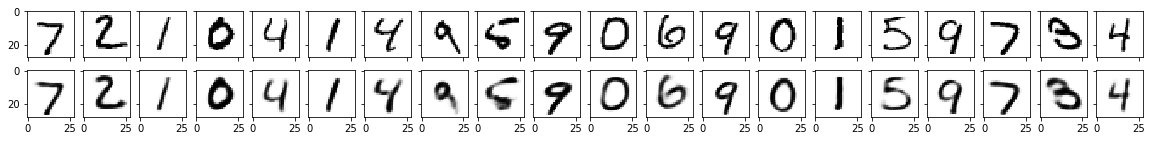

In [14]:


%matplotlib inline
import matplotlib.pyplot as plt


n_images = 20
image_width, image_height = 28, 28

images, labels = next(iter(test_loader))
print(images.shape)
fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2))
input_images = images[:n_images]
print(input_images.shape)
latent = aae_solver.encoder(input_images.to(device).view(-1, 784))[0]
print('latent-shape :: ', latent.shape)
outputs = aae_solver.generator(latent)
output_images = outputs.view(-1, 1, 28, 28).detach().cpu().numpy()

print(output_images.shape)

for i in range(n_images):
    for ax, img in zip(axes, [input_images, output_images]):
        ax[i].imshow(img[i][0], cmap='binary')

## Latent-space interpolation

In [15]:

def interpolate(x1, x2, img, col_indx, row_indx, n=20):
    X = torch.cat([x1, x2], dim=0).reshape(2, 784)
    latent = aae_solver.encoder(X.to(device))[0].detach()
    z1, z2 = latent[0], latent[1]
    z_list = []
    for i in range(n):
        zp = i*z1 / float(n-1) + (n-i-1)*z2/float(n-1)
        z_list.append(zp.reshape(1, -1))

    zp = torch.cat(z_list, dim=0)
    outputs = aae_solver.generator(zp)
    output_images = outputs.view(-1, 1, 28, 28).detach()
    #print(aae_solver.discrim(latent))
    j = 0
    for c in col_indx:
        for r in row_indx:
            img[r*28:(r+1)*28, c*28:(c+1)*28] = output_images.cpu().numpy()[j, 0, :, :]
            j = j + 1
    return img, output_images

torch.Size([1, 28, 28])


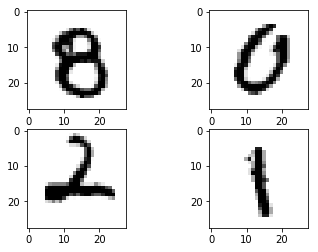

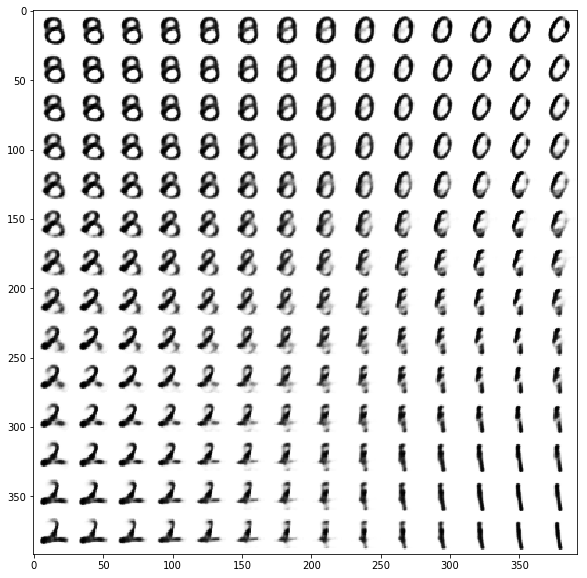

In [19]:

images, labels = next(iter(train_loader))

x1 = images[0]
x2 = images[5]
x3 = images[1]
x4 = images[13]
print(x1.shape)
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.imshow(x3.numpy()[0], cmap='binary')
ax = fig.add_subplot(2, 2, 2)
ax.imshow(x4.numpy()[0], cmap='binary')
ax = fig.add_subplot(2, 2, 3)
ax.imshow(x1.numpy()[0], cmap='binary')
ax = fig.add_subplot(2, 2, 4)
ax.imshow(x2.numpy()[0], cmap='binary')
plt.show()


    

n = 14
img = np.zeros(shape=(n*28, n*28))

img, out12 = interpolate(x2, x1, img, 
                         col_indx=np.arange(n), row_indx=[n-1], n=n) 
img, out13 = interpolate(x1, x3, img,
                         col_indx=[0], row_indx=np.arange(n), n=n)
img, out34 = interpolate(x4, x3, img,
                         col_indx=np.arange(1, n), row_indx=[0], n=n-1)
img, out24 = interpolate(x2, x4, img,
                         col_indx=[n-1], row_indx=np.arange(0, n), n=n)

for i in range(1, n-1):
    img, _ = interpolate(out24[i], out13[i], img, col_indx=np.arange(1, n-1), row_indx=[i], n=n-2)

fig = plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='binary')

torch.Size([1, 28, 28])


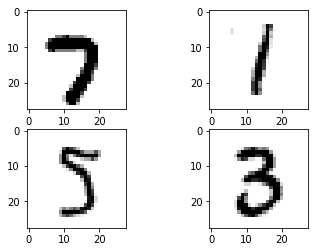

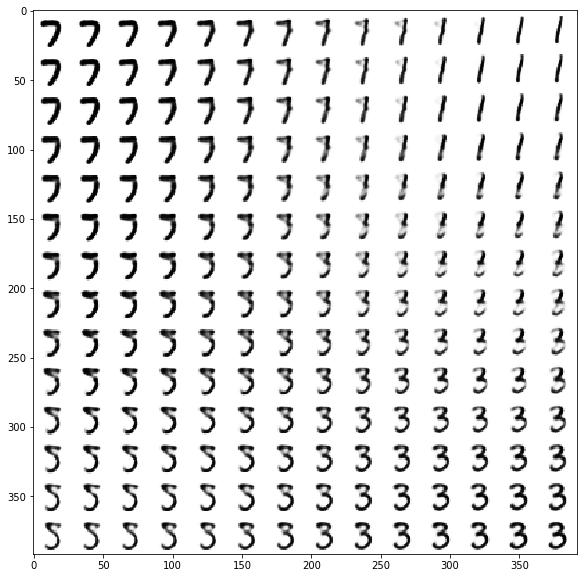

In [25]:

images, labels = next(iter(train_loader))

x1 = images[0]
x2 = images[5]
x3 = images[1]
x4 = images[13]
print(x1.shape)
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.imshow(x3.numpy()[0], cmap='binary')
ax = fig.add_subplot(2, 2, 2)
ax.imshow(x4.numpy()[0], cmap='binary')
ax = fig.add_subplot(2, 2, 3)
ax.imshow(x1.numpy()[0], cmap='binary')
ax = fig.add_subplot(2, 2, 4)
ax.imshow(x2.numpy()[0], cmap='binary')
plt.show()


    

n = 14
img = np.zeros(shape=(n*28, n*28))

img, out12 = interpolate(x2, x1, img, 
                         col_indx=np.arange(n), row_indx=[n-1], n=n) 
img, out13 = interpolate(x1, x3, img,
                         col_indx=[0], row_indx=np.arange(n), n=n)
img, out34 = interpolate(x4, x3, img,
                         col_indx=np.arange(1, n), row_indx=[0], n=n-1)
img, out24 = interpolate(x2, x4, img,
                         col_indx=[n-1], row_indx=np.arange(0, n), n=n)

for i in range(1, n-1):
    img, _ = interpolate(out24[i], out13[i], img, col_indx=np.arange(1, n-1), row_indx=[i], n=n-2)

fig = plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='binary')